Starting Portfolio Value: 100000.00
2017-01-03, Cash 100000.0 Value 100000.0
2017-01-04, Cash 100000.0 Value 100000.0
2017-01-05, Cash 100000.0 Value 100000.0
2017-01-06, Cash 100000.0 Value 100000.0
2017-01-09, Cash 100000.0 Value 100000.0
2017-01-10, Cash 100000.0 Value 100000.0
2017-01-11, Cash 100000.0 Value 100000.0
2017-01-12, Cash 100000.0 Value 100000.0
2017-01-13, Cash 100000.0 Value 100000.0
2017-01-16, Cash 100000.0 Value 100000.0
2017-01-17, Cash 100000.0 Value 100000.0
2017-01-18, Cash 100000.0 Value 100000.0
2017-01-19, Cash 100000.0 Value 100000.0
2017-01-20, Cash 100000.0 Value 100000.0
2017-01-23, Cash 100000.0 Value 100000.0
2017-01-24, Cash 100000.0 Value 100000.0
2017-01-25, Cash 100000.0 Value 100000.0
2017-01-26, Cash 100000.0 Value 100000.0
2017-01-27, Cash 100000.0 Value 100000.0
2017-01-30, Cash 100000.0 Value 100000.0
2017-01-31, Cash 100000.0 Value 100000.0
2017-02-01, Cash 100000.0 Value 100000.0
2017-02-02, Cash 100000.0 Value 100000.0
2017-02-03, Cash 1000

2018-05-09, Cash 14520.363599999993 Value 129135.3636
2018-05-09, Close, 283.00
Max price: 300.0
Min price: 275.0
2018-05-10, Cash 14520.363599999993 Value 127839.3636
2018-05-10, Close, 279.80
Max price: 300.0
Min price: 275.0
2018-05-11, Cash 14520.363599999993 Value 129945.3636
2018-05-11, Close, 285.00
Max price: 300.0
Min price: 275.0
2018-05-15, Cash 14520.363599999993 Value 129135.3636
2018-05-15, Close, 283.00
Max price: 300.0
Min price: 275.0
2018-05-16, Cash 14520.363599999993 Value 130593.36360000001
2018-05-16, Close, 286.60
Max price: 300.0
Min price: 275.0
2018-05-17, Cash 14520.363599999993 Value 129945.3636
2018-05-17, Close, 285.00
Max price: 300.0
Min price: 275.0
2018-05-18, Cash 14520.363599999993 Value 129945.3636
2018-05-18, Close, 285.00
Max price: 300.0
Min price: 275.0
2018-05-21, Cash 14520.363599999993 Value 127920.3636
2018-05-21, Close, 280.00
Max price: 300.0
Min price: 275.0
2018-05-22, Cash 14520.363599999993 Value 129540.3636
2018-05-22, Close, 284.00
M

<IPython.core.display.Javascript object>


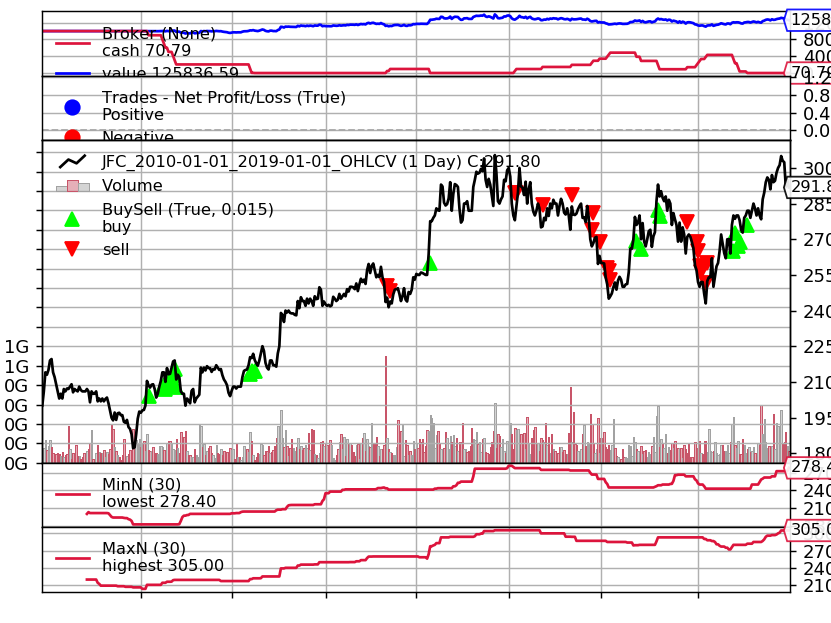

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from pkg_resources import resource_filename
import datetime
import os.path
import sys
import backtrader as bt
import backtrader.feeds as btfeed

INIT_CASH = 100000
BAND_PERIOD = 30
COMMISSION_PER_TRANSACTION = 0.006
DATA_FILE = resource_filename(__name__,'../data/JFC_2010-01-01_2019-01-01_OHLCV.csv')

class MinMaxSupportResistance(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.minn = bt.indicators.MinN(self.datas[0], period=BAND_PERIOD)
        self.maxn = bt.indicators.MaxN(self.datas[0], period=BAND_PERIOD)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def notify_cashvalue(self, cash, value):
        # Update cash and value every period
        self.log('Cash %s Value %s' % (cash, value))
        self.cash = cash
        self.value = value

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        print('Max price:', self.maxn[0])
        print('Min price:', self.minn[0])
        if self.order:
            return

        # Only buy if there is enough cash for at least one stock
        if self.cash >= self.dataclose[0]:
            # Sell if the current closing is the lowest in the last N days
            if (self.dataclose[0] == self.maxn):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                # Take a 10% long position every time it's a buy signal (or whatever is afforder by the current cash position)
                # "size" refers to the number of stocks to purchase
                self.order = self.buy(size=int(min((INIT_CASH / self.dataclose[0]) * 0.1, self.cash / self.dataclose[0])))

        # Only sell if you hold least one unit of the stock (and sell only that stock, so no short selling)
        if (self.value - self.cash) > 0:
            # Buy if the current closing is the highest in the last N days
            if (self.dataclose[0] == self.minn):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                # Sell a 5% sell position (or whatever is afforded by the current stock holding)
                # "size" refers to the number of stocks to purchase
                self.order = self.sell(size=int(min((INIT_CASH / self.dataclose[0]) * 0.05, (self.value - self.cash) / self.dataclose[0])))


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MinMaxSupportResistance)
    cerebro.broker.setcommission(commission=COMMISSION_PER_TRANSACTION)

    data = btfeed.GenericCSVData(
        dataname=DATA_FILE,

        fromdate=datetime.datetime(2017, 1, 1),
        todate=datetime.datetime(2019, 1, 1),

        nullvalue=0.0,

        dtformat=('%Y-%m-%d'),

        datetime=0,
        open=1,
        high=2,
        low=3,
        close=4,
        volume=5,
        openinterest=-1
    )
    cerebro.adddata(data)
    cerebro.broker.setcash(INIT_CASH)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(figsize=(30, 15))